In [1]:
##############################################################
# This notebook is for training a CNN for Accident detection #
# Framework is tensorflow                                    #
# This is MY usual solution that works in Most situations    #
# with reasonable Accuracy                                   #
# Thanks                                                     #
##############################################################

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter
import os
  

In [3]:
import mlflow
from mlflow import pyfunc
import mlflow.keras

experiment_name = 'Accidents-Classification'
mlflow.set_experiment(experiment_name)

mlflow.keras.autolog()

2022/10/04 16:54:56 INFO mlflow.tracking.fluent: Experiment with name 'Accidents-Classification' does not exist. Creating a new experiment.
c:\Users\yahya_abbas\Miniconda3\envs\ml_env\lib\site-packages\mlflow\utils\autologging_utils\__init__.py:416: FutureWarning: Autologging support for keras >= 2.6.0 has been deprecated and will be removed in a future MLflow release. Use `mlflow.tensorflow.autolog()` instead.
  return _autolog(*args, **kwargs)


In [4]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [5]:
## loading training set
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 791 files belonging to 2 classes.


In [6]:
## loading validation dataset
validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)


Found 98 files belonging to 2 classes.


In [7]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)

class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 100 files belonging to 2 classes.


In [8]:
# Defining Cnn

MyCnn = tf.keras.models.Sequential([
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation= 'softmax')
    ])

MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
# retVal = MyCnn.fit(training_ds, validation_data= validation_ds, epochs = 1)

# mlflow.keras.autolog()

with mlflow.start_run(run_name="Cnn_model") as run:
    ## lets train our CNN
    # MyCnn.fit(training_ds, validation_data=validation_ds, epochs=10)
    MyCnn.fit(training_ds, validation_data=validation_ds, epochs=3)

2022/10/04 16:55:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.


Epoch 1/3
8/8 [==============================] - 267s 24s/step - loss: 8.3291 - accuracy: 0.4779 - val_loss: 2.8786 - val_accuracy: 0.5306
Epoch 2/3
8/8 [==============================] - 208s 27s/step - loss: 0.7078 - accuracy: 0.5929 - val_loss: 0.6790 - val_accuracy: 0.5816
Epoch 3/3
8/8 [==============================] - 146s 17s/step - loss: 0.6443 - accuracy: 0.6346 - val_loss: 0.6281 - val_accuracy: 0.6122


INFO:tensorflow:Assets written to: C:\Users\YAHYA_~1\AppData\Local\Temp\tmpcg6_j3os\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\YAHYA_~1\AppData\Local\Temp\tmpcg6_j3os\model\data\model\assets
c:\Users\yahya_abbas\Miniconda3\envs\ml_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


c:\Users\yahya_abbas\Miniconda3\envs\ml_env\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


4/4 [==============================] - 4s 840ms/step


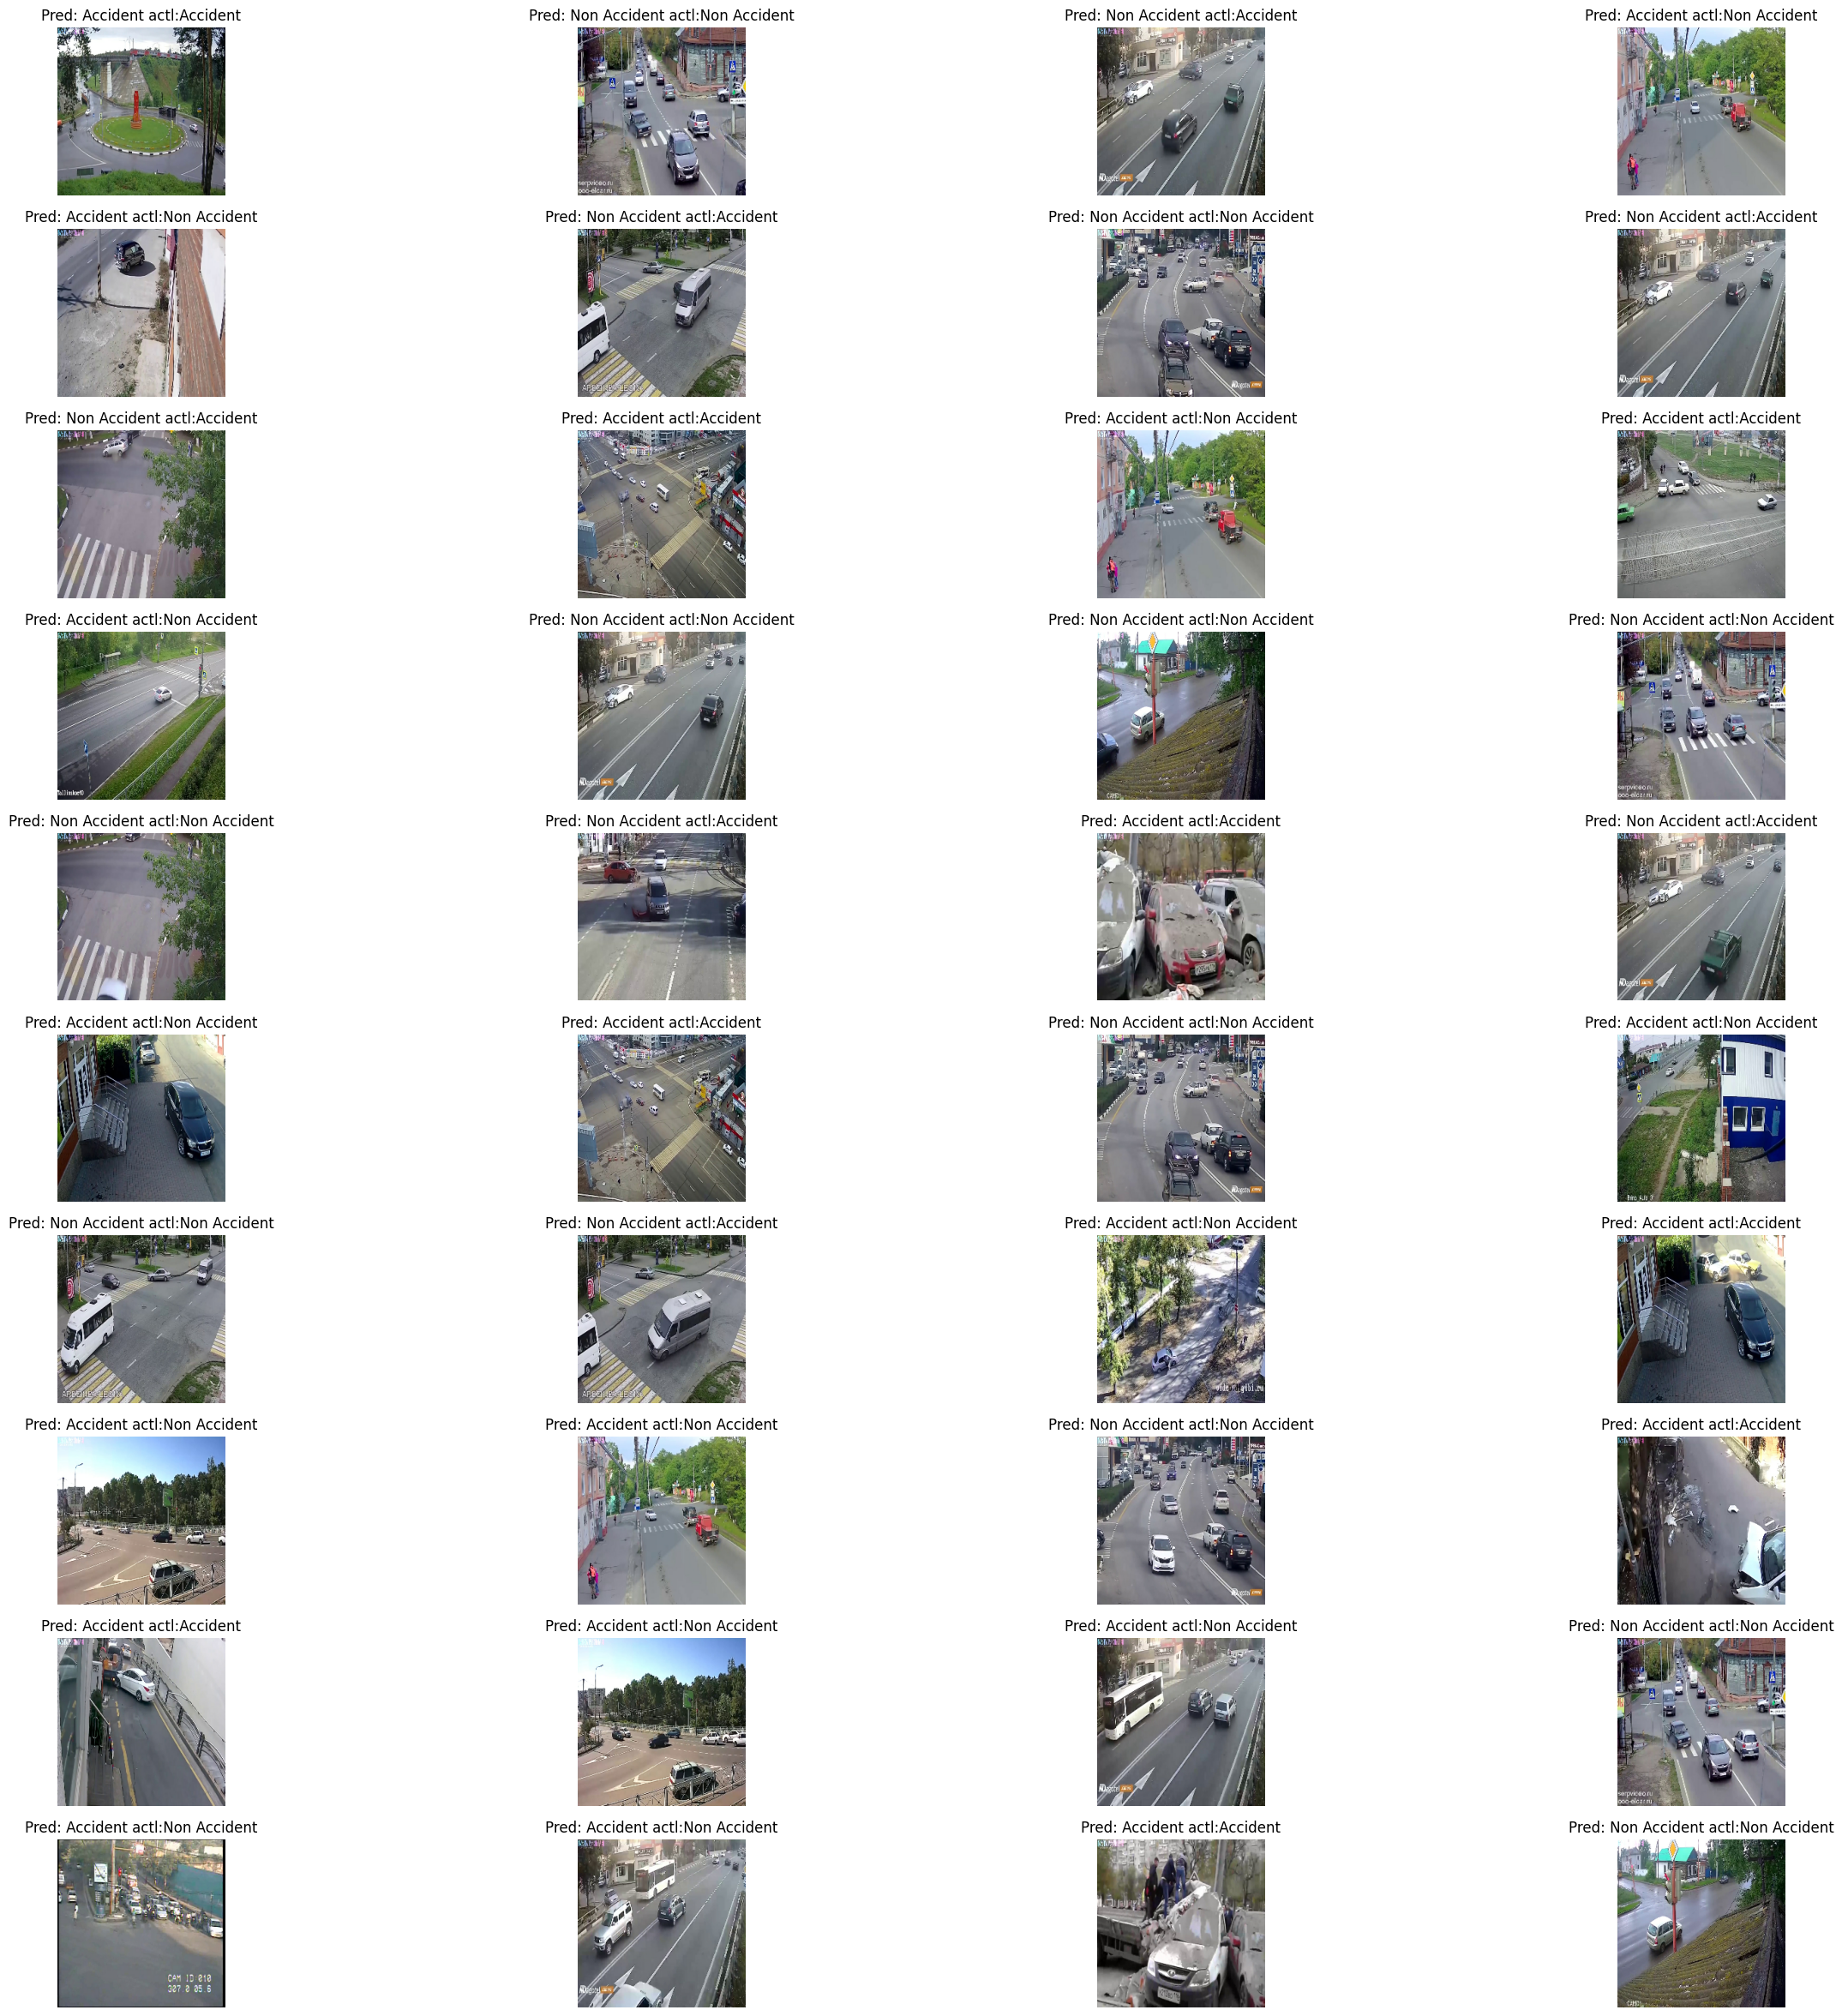

In [10]:
## lets vizualize results on testing data
AccuracyVector = []

# load the model saved by mlflow tracking
pyfunc_model = pyfunc.load_model(run.info.artifact_uri + "/model")

plt.figure(figsize=(30, 30))
for images, labels in testing_ds.take(1):
    predictions = pyfunc_model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)